We test whether TDE can enhace prediction abilities of ESNs applied to the Lorenz System.

In [1]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [2]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\lisah\.julia\packages\Flux\9PibT\ext\FluxCUDAExt\FluxCUDAExt.jl:10


## Simulating Lorenz Data

In [3]:
# Set up the Lorenz system and generate data
lorenz = Systems.lorenz63()

# Integrate the system
T = 200.0
Δt = 0.1
Ttr = 100.0  # Transient that will be discarded

tr = trajectory(lorenz, T, Δt = Δt, Ttr = Ttr)
x, y, z = columns(tr[1])

# Put the data in the matrix format (n_features, n_samples) required by ReservoirComputing.jl 
data = copy(hcat(x, y, z)')

3×2001 Matrix{Float64}:
  -7.9554  -15.3466  -13.1091  -3.50536  …   2.60804   4.85809   9.20262
 -14.5316  -21.0154   -3.5192   3.71577      4.24185   7.98143  14.6799
  12.6248   30.0779   41.0784  30.7804      17.4522   15.3366   18.8447

In [4]:
l_max = lyapunov(lorenz, 100, Ttr = 100)

0.8986638632954478

In [5]:
# make data stochastic
var = 4
data_rand = data + var * randn(size(data)) 

3×2001 Matrix{Float64}:
 -11.8701  -22.3871  -19.0838  -2.34692  …  -1.22035   2.48331  17.763
 -10.2325  -18.8649   -8.076   -1.28614      5.03936   6.4145    8.39244
  16.3829   27.9044   46.848   26.6642      19.677    17.7667   16.7682

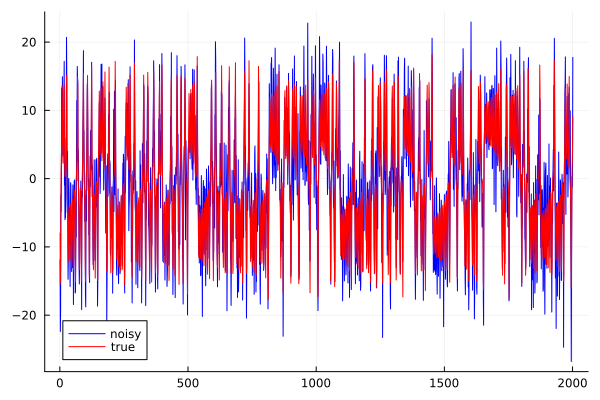

In [6]:
# visually check stochasticity
plot(data_rand[1, :], color="blue", label = "noisy")
plot!(data[1,:], color = "red", label ="true")

## Tools

In [15]:
"""
    train_val_test_split(data; val_seconds, test_seconds, Δt = 0.1)

Split the given data into training, validation, and test sets.
"""
function train_val_test_split(data, N_train, N_val)
    
    ind = N_train + N_val
    
    train_data = data[:, 1:N_train]
    val_data = data[:, N_train+1:ind]
    test_data = data[:, ind+1:end]
    
    return train_data, val_data, test_data
end

train_val_test_split

In [16]:
"""
    plot_prediction_tde_sep(esn_x, esn_y, esn_z, W_x, W_y, W_z, test_data_x,test_data_y,test_data_z, λ_max, title)

plot predictions versus the given test set, when TDE is performed seperately on different observables
"""
function plot_prediction_sep(esn_x, esn_y, esn_z, W_x, W_y, W_z, test_data_x,test_data_y,test_data_z, λ_max, title)
    
    prediction_x = esn_x(Generative(size(test_data_x, 2)), W_x)
    prediction_y = esn_y(Generative(size(test_data_y, 2)), W_y)
    prediction_z = esn_z(Generative(size(test_data_z, 2)), W_z)
    
    label = ["actual" "predicted"]
    times_x = Δt * collect(0:size(test_data_x, 2))[1:end-1] / λ_max
    times_y = Δt * collect(0:size(test_data_y, 2))[1:end-1] / λ_max
    times_z = Δt * collect(0:size(test_data_z, 2))[1:end-1] / λ_max

    print(test_data_z[1,:])

    p1 = plot(times_x, [test_data_x[1, :], prediction_x[1, :]], label = label, ylabel = "x(t)")
    p2 = plot(times_y, [test_data_y[1, :], prediction_y[1, :]], label = label, ylabel = "y(t)")
    p3 = plot(times_z, [test_data_z[1, :], prediction_z[1, :]], label = label, ylabel = "z(t)", xlabel = "t * λ_max")
    plot(p1, p2, p3, layout = (3, 1), size = (800, 600), title=title)
end

plot_prediction_sep

In [17]:
"""
    plot_comparison(esn_1d, esn_tde, W_1d, W_tde, test_data, λ_max, title)

"""
function plot_comparison(esn_1d, esn_tde, W_1d, W_tde, test_data, λ_max, title)

    prediction_size = size(test_data, 2)
    
    prediction_1d = esn_1d(Generative(prediction_size), W_1d)
    prediction_tde = esn_1d(Generative(prediction_size), W_tde)
    
    label = ["actual" "predicted"]
    times = Δt * collect(0:steps_to_predict)[1:end-1] / λ_max

    p2 = plot(times, [test_data[1, :], prediction_1d[1, :]], label = label, ylabel = "")
    p3 = plot(times, [test_data[1, :], prediction_tde[1, :]], label = label, ylabel = "", xlabel = "t * λ_max")
    plot(p2, p3, layout = (2, 1), size = (800, 600), title=title)
end

plot_comparison

In [18]:
"""
    plot_prediction(esn, Wₒᵤₜ, test_data, λ_max)

Given an Echo State Network, plot its predictions versus the given test set.
"""
function plot_prediction(esn, Wₒᵤₜ, test_data, λ_max, title)
    steps_to_predict = size(test_data, 2)
    prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)
    
    label = ["actual" "predicted"]
    times = Δt * collect(0:steps_to_predict)[1:end-1] / λ_max

    p1 = plot(times, [test_data[1, :], prediction[1, :]], label = label, ylabel = "x(t)")
    p2 = plot(times, [test_data[2, :], prediction[2, :]], label = label, ylabel = "y(t)")
    p3 = plot(times, [test_data[3, :], prediction[3, :]], label = label, ylabel = "z(t)", xlabel = "t * λ_max")
    plot(p1, p2, p3, layout = (3, 1), size = (800, 600), title=title)
end

plot_prediction

## TDE on each observable seperately

we perform a TDE of a 1D observation of the Lorenz System

In [19]:
# use random data 
data = data_rand

3×2001 Matrix{Float64}:
 -11.8701  -22.3871  -19.0838  -2.34692  …  -1.22035   2.48331  17.763
 -10.2325  -18.8649   -8.076   -1.28614      5.03936   6.4145    8.39244
  16.3829   27.9044   46.848   26.6642      19.677    17.7667   16.7682

In [20]:
# perform TDE on x_data 
x_data_emb, τ, E = optimal_separated_de(data[1,:])
y_data_emb, τ, E = optimal_separated_de(data[2,:])
z_data_emb, τ, E = optimal_separated_de(data[3,:])

n = minimum([length(x_data_emb), length(y_data_emb),length(z_data_emb)])
x_data_emb = x_data_emb[1:n,:]
y_data_emb = y_data_emb[1:n,:]
z_data_emb = z_data_emb[1:n,:];

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.
Stochastic signal, valid embedding NOT achieved ⨉.
Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.
Stochastic signal, valid embedding NOT achieved ⨉.
Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


In [21]:
N_train = floor(Int, n * 0.8)
N_val = floor(Int, (n-N_train) /2)
N_test = n - N_train - N_val

198

In [22]:
train_x_data_emb, val_x_data_emb, test_x_data_emb = train_val_test_split(Matrix(x_data_emb)', N_train, N_val)
train_y_data_emb, val_y_data_emb, test_y_data_emb = train_val_test_split(Matrix(y_data_emb)', N_train, N_val)
train_z_data_emb, val_z_data_emb, test_z_data_emb = train_val_test_split(Matrix(z_data_emb)', N_train, N_val)


([16.38286657830458 27.904378774022312 … 37.250532071839174 27.379173880239627; 46.848008603798306 26.66424628710862 … 19.923127614415954 25.301019100925892; … ; 36.85410501507434 40.04413985499117 … 31.274629669455944 17.80890525813534; 31.33087309761977 30.098522541197273 … 17.366915180845464 17.30122622504625], [19.923127614415954 25.301019100925892 … 37.837901803419626 40.7460080360333; 14.119128912307296 34.057965826495334 … 32.668174855903985 29.827488056684004; … ; 17.366915180845464 17.30122622504625 … 37.512283033964074 28.71514521929364; 27.268485014222843 32.604449798655494 … 25.97615485642132 17.736798733742486], [32.668174855903985 29.827488056684004 … 15.847307038123073 26.348393709381973; 22.99754831929929 15.458556795718795 … 27.00399807181796 29.539802021997293; … ; 25.97615485642132 17.736798733742486 … 15.450020584448971 30.97491983491213; 17.30458383064334 17.773578026242305 … 36.67595175170772 27.63044766103809])

In [23]:
spectral_radii = [0.8, 0.9, 1.0, 1.2]
sparsities = [0.03, 0.05, 0.14, 0.1]
input_scales = [0.1, 0.5, 1.0, 2.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [450, 470, 490, 1000]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

esn_x_emb, W_out_x_emb, val_loss_x_emb = enso_project.cross_validate_esn(train_x_data_emb, val_x_data_emb, param_grid)

enso_project.ESNHyperparams(450, 0.8, 0.03, 0.1, 0.0)
Validation loss = 192486.87522742874
enso_project.ESNHyperparams(450, 0.9, 0.03, 0.1, 0.0)
Validation loss = 122421.18629864324
enso_project.ESNHyperparams(450, 0.8, 0.14, 0.1, 0.0)
Validation loss = 109785.49055531576
enso_project.ESNHyperparams(450, 1.2, 0.14, 0.1, 0.0)
Validation loss = 102101.46057641062
enso_project.ESNHyperparams(450, 1.0, 0.14, 0.1, 1.0e-5)
Validation loss = 96334.39331189453


(ESN(6 => 450), OutputLayer successfully trained with output size: 6, 96334.39331189453)

In [24]:
spectral_radii = [0.8, 0.9, 1.0, 1.2]
sparsities = [0.03, 0.05, 0.14, 0.1]
input_scales = [0.1, 0.5, 1.0, 2.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [600, 650, 700, 750, 800]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

esn_y_emb, W_out_y_emb, val_loss_y_emb = enso_project.cross_validate_esn(train_y_data_emb, val_y_data_emb, param_grid)

enso_project.ESNHyperparams(600, 0.8, 0.03, 0.1, 0.0)
Validation loss = 197124.08765140543
enso_project.ESNHyperparams(600, 0.9, 0.03, 0.1, 0.0)
Validation loss = 190543.4310142192
enso_project.ESNHyperparams(700, 0.9, 0.03, 0.1, 0.0)
Validation loss = 176730.90930168604
enso_project.ESNHyperparams(600, 0.8, 0.14, 0.1, 0.0)
Validation loss = 172446.0929343772
enso_project.ESNHyperparams(600, 0.9, 0.14, 0.1, 0.0)
Validation loss = 153673.49053503296
enso_project.ESNHyperparams(600, 1.2, 0.14, 0.1, 0.0)
Validation loss = 146155.57083316246
enso_project.ESNHyperparams(600, 1.2, 0.14, 2.0, 0.0)
Validation loss = 111651.3578598043


(ESN(6 => 600), OutputLayer successfully trained with output size: 6, 111651.3578598043)

In [26]:
spectral_radii = [0.9]
sparsities = [0.05, 0.14]
input_scales = [0.1, 0.5, 1.0, 2.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [560, 600]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

esn_z_emb, W_out_z_emb, val_loss_z_emb = enso_project.cross_validate_esn(train_z_data_emb, val_z_data_emb, param_grid)

enso_project.ESNHyperparams(560, 0.9, 0.05, 0.1, 0.0)
Validation loss = 201690.58572936885
enso_project.ESNHyperparams(560, 0.9, 0.05, 0.1, 1.0e-6)
Validation loss = 200197.2979512124
enso_project.ESNHyperparams(600, 0.9, 0.05, 0.1, 1.0e-6)
Validation loss = 139382.57825377188
enso_project.ESNHyperparams(560, 0.9, 0.05, 2.0, 1.0e-6)
Validation loss = 119504.75194288719
enso_project.ESNHyperparams(560, 0.9, 0.14, 2.0, 1.0e-5)
Validation loss = 119485.98059786101


(ESN(6 => 560), OutputLayer successfully trained with output size: 6, 119485.98059786101)

## ESN training without TDE

In [28]:
data = data[:,1:n]

x_data_1d = Matrix(data[1,:]')
y_data_1d = Matrix(data[2,:]')
z_data_1d = Matrix(data[3,:]')


train_data_x_1D, val_data_x_1D, test_data_x_1D = train_val_test_split(x_data_1d, N_train, N_val)
train_data_y_1D, val_data_y_1D, test_data_y_1D = train_val_test_split(y_data_1d, N_train, N_val)
train_data_z_1D, val_data_z_1D, test_data_z_1D = train_val_test_split(z_data_1d, N_train, N_val)

([16.38286657830458 27.904378774022312 … 37.250532071839174 27.379173880239627], [19.923127614415954 25.301019100925892 … 37.837901803419626 40.7460080360333], [32.668174855903985 29.827488056684004 … 15.847307038123073 26.348393709381973])

In [29]:
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03, 0.05]
input_scales = [0.1, 0.5]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [512, 1024]

param_grid_x = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [30]:
# network training
esn_x_1D, W_out_x_1D, val_loss_x_1D = enso_project.cross_validate_esn(train_data_x_1D, val_data_x_1D, param_grid_x)

enso_project.ESNHyperparams(512, 0.8, 0.03, 0.1, 0.0)
Validation loss = 29628.698801408682
enso_project.ESNHyperparams(512, 0.8, 0.05, 0.1, 0.0)
Validation loss = 24771.576224426255
enso_project.ESNHyperparams(512, 1.0, 0.05, 0.1, 0.0)
Validation loss = 20532.123669677047
enso_project.ESNHyperparams(512, 1.0, 0.05, 0.1, 1.0e-6)
Validation loss = 20126.285066606466


(ESN(1 => 512), OutputLayer successfully trained with output size: 1, 20126.285066606466)

In [31]:
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03, 0.05]
input_scales = [0.1, 0.5]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [512, 1024]

param_grid_y = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [32]:
esn_y_1D, W_out_y_1D, val_loss_y_1D = enso_project.cross_validate_esn(train_data_y_1D, val_data_y_1D, param_grid_y)

enso_project.ESNHyperparams(512, 0.8, 0.03, 0.1, 0.0)
Validation loss = 31993.45979152358
enso_project.ESNHyperparams(512, 0.8, 0.05, 0.1, 0.0)
Validation loss = 28754.202911805107


(ESN(1 => 512), OutputLayer successfully trained with output size: 1, 28754.202911805107)

In [33]:
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03, 0.05]
input_scales = [0.1, 0.5]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [512, 1024]

param_grid_z = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [34]:
esn_z_1D, W_out_z_1D, val_loss_z_1D = enso_project.cross_validate_esn(train_data_z_1D, val_data_z_1D, param_grid_z)

enso_project.ESNHyperparams(512, 0.8, 0.03, 0.1, 0.0)
Validation loss = 45771.30604970198
enso_project.ESNHyperparams(512, 1.2, 0.03, 0.1, 0.0)
Validation loss = 30557.607511663697
enso_project.ESNHyperparams(512, 1.2, 0.03, 0.5, 0.0)
Validation loss = 25926.90817539276
enso_project.ESNHyperparams(512, 0.8, 0.03, 0.5, 1.0e-6)
Validation loss = 22121.708779886194
enso_project.ESNHyperparams(1024, 0.8, 0.03, 0.5, 1.0e-6)
Validation loss = 19438.21597083872
enso_project.ESNHyperparams(512, 0.8, 0.05, 0.5, 1.0e-6)
Validation loss = 19147.073735730362
enso_project.ESNHyperparams(1024, 0.8, 0.05, 0.5, 1.0e-6)
Validation loss = 19043.8138209778
enso_project.ESNHyperparams(512, 1.0, 0.05, 0.5, 1.0e-6)
Validation loss = 18885.662548110904
enso_project.ESNHyperparams(512, 0.8, 0.03, 0.5, 1.0e-5)
Validation loss = 17604.34971231159


(ESN(1 => 512), OutputLayer successfully trained with output size: 1, 17604.34971231159)

## Comparison

[32.668174855903985, 29.827488056684004, 22.99754831929929, 15.458556795718795, 33.39902917124459, 31.97613765294154, 37.512283033964074, 28.71514521929364, 25.97615485642132, 17.736798733742486, 17.30458383064334, 17.773578026242305, 28.384257891202385, 36.706511902375496, 27.900803175980307, 28.55111231332319, 20.697872842565225, 12.887689315299946, 12.209950778504084, 13.410433894483441, 32.559652536332706, 35.35401886038342, 29.212132521032313, 23.34903603525476, 7.540618730327523, 12.5302110492959, 13.260403160836184, 22.633466804678676, 36.55832782963787, 36.64390835126693, 30.493060301593836, 18.128762435038848, 11.4075992832846, 12.309623446512454, 6.657061852036745, 11.128517619829811, 37.69439502556495, 31.975895032394366, 24.39406384961743, 19.66711895035715, 10.962805983214588, 13.070539370360805, 18.05593635682649, 26.66206384025292, 47.6295236178856, 32.47081830188157, 26.718119697944154, 25.36505751618264, 23.38171663215972, 14.39989251902018, 13.591537102968475, -0.0121

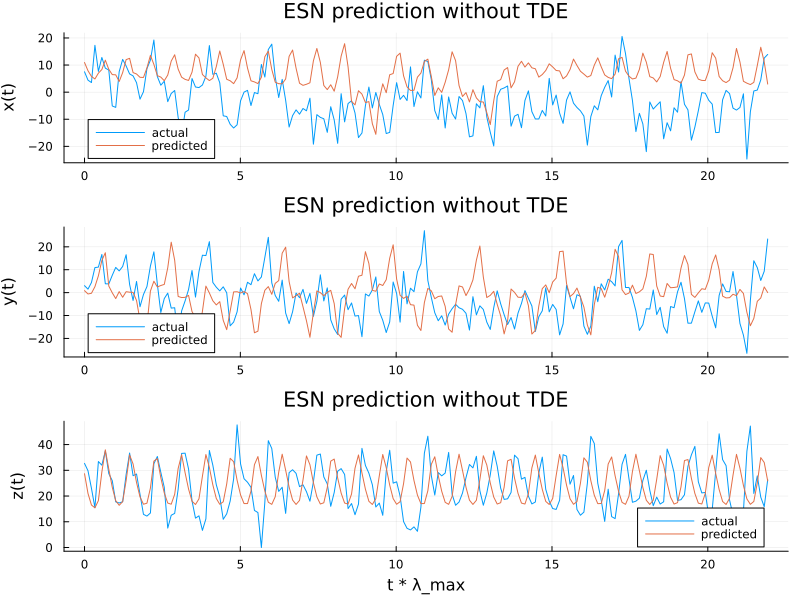

In [35]:
plot_prediction_sep(esn_x_1D,esn_y_1D,esn_z_1D, W_out_x_1D,  W_out_y_1D, W_out_z_1D,test_data_x_1D,test_data_y_1D,test_data_z_1D, l_max, "ESN prediction without TDE")

[32.668174855903985, 29.827488056684004, 22.99754831929929, 15.458556795718795, 33.39902917124459, 31.97613765294154, 37.512283033964074, 28.71514521929364, 25.97615485642132, 17.736798733742486, 17.30458383064334, 17.773578026242305, 28.384257891202385, 36.706511902375496, 27.900803175980307, 28.55111231332319, 20.697872842565225, 12.887689315299946, 12.209950778504084, 13.410433894483441, 32.559652536332706, 35.35401886038342, 29.212132521032313, 23.34903603525476, 7.540618730327523, 12.5302110492959, 13.260403160836184, 22.633466804678676, 36.55832782963787, 36.64390835126693, 30.493060301593836, 18.128762435038848, 11.4075992832846, 12.309623446512454, 6.657061852036745, 11.128517619829811, 37.69439502556495, 31.975895032394366, 24.39406384961743, 19.66711895035715, 10.962805983214588, 13.070539370360805, 18.05593635682649, 26.66206384025292, 47.6295236178856, 32.47081830188157, 26.718119697944154, 25.36505751618264, 23.38171663215972, 14.39989251902018, 13.591537102968475, -0.0121

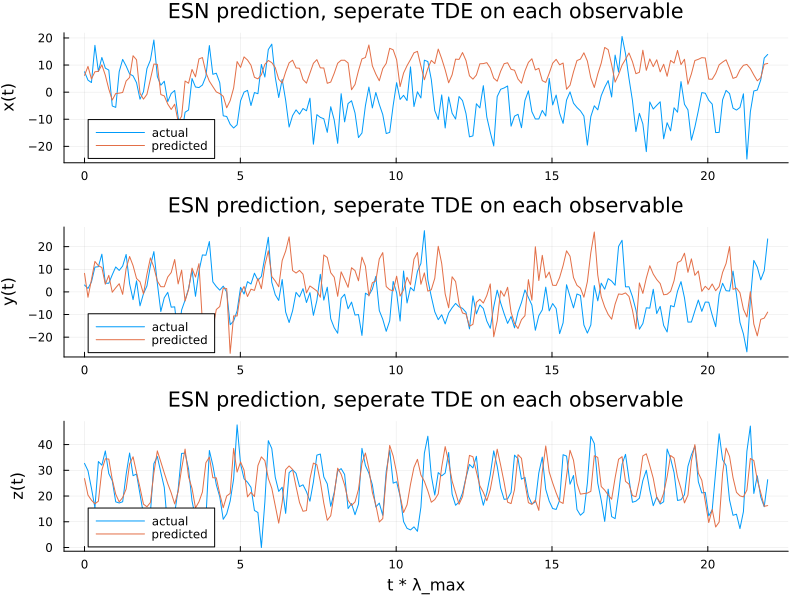

In [27]:
plot_prediction_sep(esn_x_emb, esn_y_emb,esn_z_emb, W_out_x_emb,W_out_y_emb, W_out_z_emb, test_x_data_emb,test_y_data_emb,test_z_data_emb, l_max, "ESN prediction, seperate TDE on each observable")

## Plot error curves

In [36]:
# compute predictions
steps_to_predict = size(test_data_x_1D, 2)
prediction_x = esn_x_1D(Generative(steps_to_predict), W_out_x_1D)[1,:]
prediction_y = esn_y_1D(Generative(steps_to_predict), W_out_y_1D)[1,:]
prediction_z = esn_z_1D(Generative(steps_to_predict), W_out_z_1D)[1,:]

prediction_x_emb = esn_x_emb(Generative(steps_to_predict), W_out_x_emb)[1,:]
prediction_y_emb = esn_y_emb(Generative(steps_to_predict), W_out_y_emb)[1,:]
prediction_z_emb = esn_z_emb(Generative(steps_to_predict), W_out_z_emb)[1,:];

In [37]:
times = Δt*collect(0:steps_to_predict)[1:end-1] / l_max;

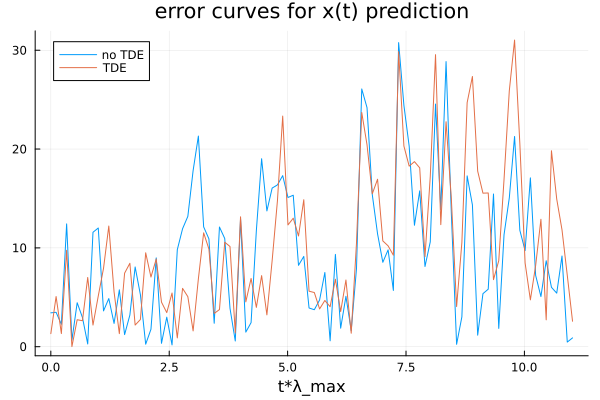

In [45]:
plot(times[1:100], abs.(prediction_x-test_data_x_1D[1,:])[1:100],label = "no TDE", title="error curves for x(t) prediction")
plot!(times[1:100],abs.(prediction_x_emb-test_data_x_1D[1,:])[1:100], label ="TDE", xlabel="t*λ_max")

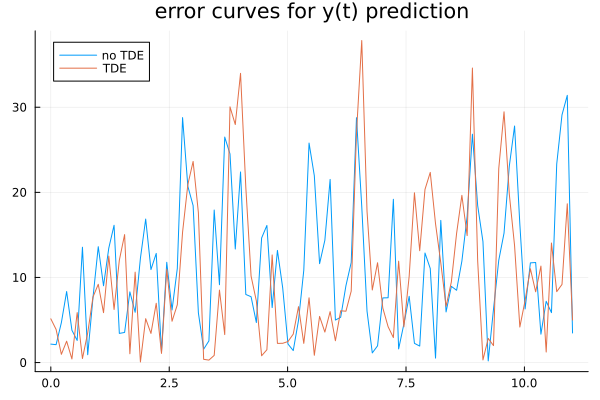

In [46]:
plot(times[1:100], abs.(prediction_y-test_data_y_1D[1,:])[1:100],label = "no TDE", title="error curves for y(t) prediction")
plot!(times[1:100], abs.(prediction_y_emb-test_data_y_1D[1,:])[1:100], label ="TDE")

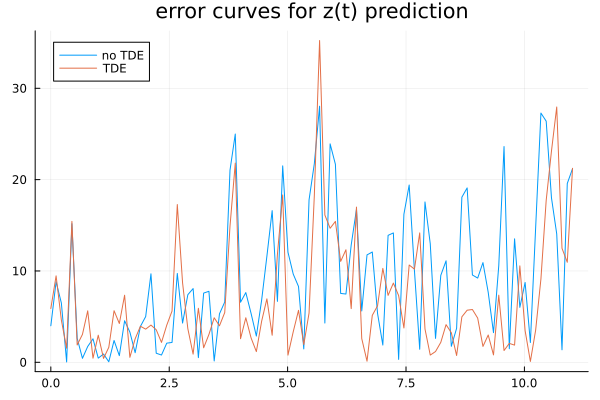

In [47]:
plot(times[1:100],abs.(prediction_z-test_data_z_1D[1,:])[1:100],label = "no TDE", title="error curves for z(t) prediction")
plot!(times[1:100],abs.(prediction_z_emb-test_data_z_1D[1,:])[1:100], label ="TDE")